# PERBANDINGAN METODE KLASTER K-MEDOIDS DAN K-MEANS TERHADAP HASIL PERAMALAN KEMISKINAN DI INDONESIA MENGGUNAKAN BPNN
### by Riansyah Fazar Ramadhan

## 1. Import Dependencies

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

## 2. Data Loading

In [2]:
data = pd.read_excel('E:\GitHub\sherlock-final-project\pooled_data.xlsx', sheet_name="data")
data = data.iloc[:, 1:4]
data_ar = np.array(data)

## 3. Terasvirta Linearity Test
#### Done in R language, check at terasvirta_acfpacf.R

## 4. ACF-PACF Test
#### Done in R language, check at terasvirta_acfpacf.R

## 5. Min-Max Normalization

In [4]:
def normalize_data(data):
    scaler = MinMaxScaler(feature_range=(-1,1))
    data_norm = scaler.fit_transform(data)
    return data_norm, scaler

x1_norm, x1_scaler = normalize_data(data_ar[:,0].reshape(-1,1))
x2_norm, x2_scaler = normalize_data(data_ar[:,1].reshape(-1,1))
x3_norm, x3_scaler = normalize_data(data_ar[:,2].reshape(-1,1))

## 6. Data Splitting and Windowing

In [5]:
def windowed_dataset(series, batch_size, n_past, n_future, shift):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(size=n_past + n_future, shift=shift, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(n_past + n_future))
    ds = ds.map(lambda w: (w[:n_past], w[n_past:]))
    return ds.batch(batch_size).prefetch(1)

In [6]:
BATCH_SIZE = 1
N_FUTURE = 1
SHIFT = 1
SPLIT_TIME = 476

In [7]:
x1_train = x1_norm[:SPLIT_TIME,]
x1_test = x1_norm[SPLIT_TIME:,]
x2_train = x2_norm[:SPLIT_TIME,]
x2_test = x2_norm[SPLIT_TIME:,]
x3_train = x3_norm[:SPLIT_TIME,]
x3_test = x3_norm[SPLIT_TIME:,]

train_set1 = windowed_dataset(series=x1_train, batch_size=BATCH_SIZE,
                            n_past=34, n_future=N_FUTURE,
                            shift=SHIFT)
test_set1 = windowed_dataset(series=x1_test, batch_size=BATCH_SIZE,
                            n_past=34, n_future=N_FUTURE,
                            shift=SHIFT)

train_set2 = windowed_dataset(series=x2_train, batch_size=BATCH_SIZE,
                            n_past=34, n_future=N_FUTURE,
                            shift=SHIFT)
test_set2 = windowed_dataset(series=x2_test, batch_size=BATCH_SIZE,
                            n_past=34, n_future=N_FUTURE,
                            shift=SHIFT)

train_set3 = windowed_dataset(series=x3_train, batch_size=BATCH_SIZE,
                            n_past=34, n_future=N_FUTURE,
                            shift=SHIFT)
test_set3 = windowed_dataset(series=x3_test, batch_size=BATCH_SIZE,
                            n_past=34, n_future=N_FUTURE,
                            shift=SHIFT)

## 7. Neural Network Architecture and Modelling

In [10]:
def modelling(train_dataset, test_dataset, epoch, loss_function, optimizer, activation, hidden_node, replication, data_index):
        model = tf.keras.models.Sequential([
                tf.keras.layers.Input(shape=(34,)),
                tf.keras.layers.Dense(hidden_node, activation=activation),
                tf.keras.layers.Dense(1)
                ])
        model.compile(loss=loss_function, optimizer=optimizer)
        early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
        history = model.fit(train_dataset, epochs=epoch, validation_data=test_dataset, callbacks=[early_stopping])
        if __name__ == '__main__':
                model.save(f"model_x{data_index}_{replication}_{hidden_node}.h5")
        train_loss = history.history['loss'][-1]
        test_loss = history.history['val_loss'][-1]
        train_epoch = len(history.epoch)
        weights = model.get_weights()
        return train_loss, test_loss, train_epoch, weights[0], weights[1], weights[2], weights[3]

In [ ]:
train_sets = [train_set1, train_set2, train_set3]
test_sets = [test_set1, test_set2, test_set3]
data_index = 0

for train_set, test_set in zip(train_sets, test_sets):
    data_index += 1
    model_sum = pd.DataFrame(columns=['replication', 'hidden_node', 'train_mse', 'test_mse', 'epoch', 'hl_weights', 'hl_bias', 'ol_weights', 'ol_bias'])
    for rep in range(1, 6):
        iterasi = (rep - 1) * 20 + 1
        for n in range(1, 21):
            a,b,c,d,e,f,g = modelling(train_dataset=train_set, 
                                    test_dataset=test_set,
                                    epoch=50, 
                                    loss_function='mse',
                                    optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),
                                    activation='relu',
                                    hidden_node=n,
                                    replication=rep,
                                    data_index=data_index)
            idx = iterasi + n
            model_sum.loc[idx] = [rep,n,a,b,c,d,e,f,g]
    model_sum.to_excel(f'model_x{data_index}_summary.xlsx')                

## 9. Prediction

In [12]:
modelx1 = tf.keras.models.load_model('x1/model_x1_5_10.h5')
modelx2 = tf.keras.models.load_model('x2/model_x2_1_2.h5')
modelx3 = tf.keras.models.load_model('x3/model_x3_4_1.h5')

### X1 (Tingkat Pertumbuhan Ekonomi)

1/1 [==============================] - 0s 21ms/step
[0.09196033 0.11986459 0.07604076 0.10087073 0.05968881 0.11875726
 0.08687723 0.1267263  0.00793416 0.12689647 0.07715819 0.11657745
 0.14414343 0.11902431 0.1262155  0.15239379 0.15862474 0.0832802
 0.08724166 0.12515534 0.15106833 0.16116494 0.14713676 0.18682347
 0.08679719 0.3629794  0.10536763 0.12084314 0.12564501 0.14947145
 0.11180726 0.5831186  0.15035753 0.2682485  0.0894459  0.14314087
 0.08150491 0.12078933 0.05826142 0.11261844 0.09409632 0.1417928
 0.00091328 0.14008418 0.0833398  0.12095943 0.16251342 0.14336722
 0.13998054 0.18777654 0.1643378  0.1420716  0.1297402  0.14714721
 0.16714974 0.17804286 0.15661262 0.22052674 0.09017589 0.3236978
 0.12243313 0.12514108 0.12767017 0.14631057 0.13106142 0.45257658
 0.17306282 0.2410945  0.08357304 0.15112963 0.07491648 0.12683256
 0.06806099 0.10856629 0.10069907 0.15439183 0.0296886  0.1505402
 0.09634319 0.126338   0.17585981 0.16362153 0.14352155 0.21264023
 0.16819799 0.

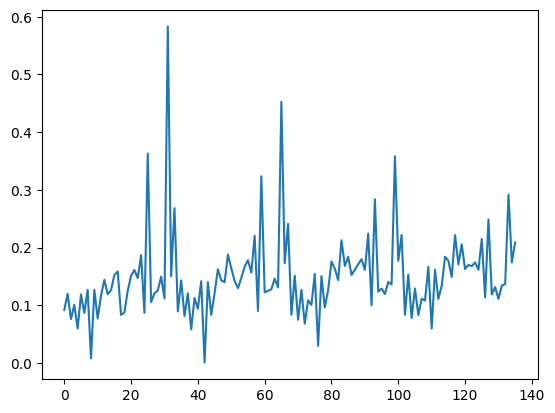

In [13]:
initial_input_data = x1_norm[-34:,].reshape(1, -1)

# Number of future data points to predict
num_predictions = 136

# Placeholder for the predictions
predictions = []

# Initial input
current_input = initial_input_data

for _ in range(num_predictions):
    # Predict the next data point
    next_pred = modelx1.predict(current_input)
    
    # Append the prediction to the predictions list
    predictions.append(next_pred.squeeze())
    
    # Update the current input data for the next prediction
    # Drop the oldest point and append the new prediction
    current_input = np.append(current_input[:, 1:], next_pred, axis=1)

# Convert the list of predictions to a NumPy array
x1predictions = np.array(predictions)

print(x1predictions)
plt.plot(x1predictions)

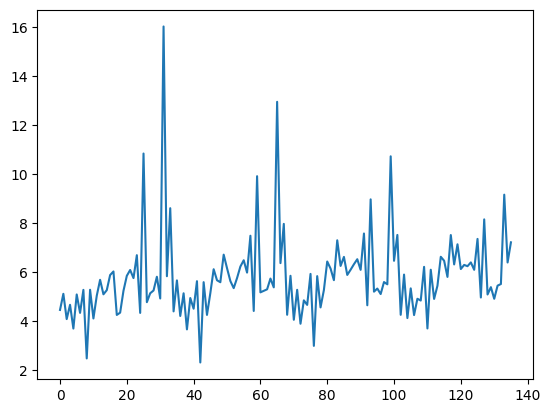

In [14]:
x1predictions = x1predictions.reshape(-1,1)
x1_pred = x1_scaler.inverse_transform(x1predictions).flatten()
plt.plot(x1_pred)

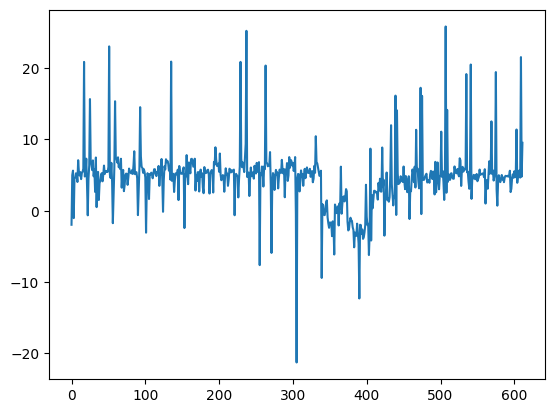

In [15]:
plt.plot(data['x1'])

### X2 (Tingkat Pengangguran Terbuka)

In [16]:
initial_input_data = x2_norm[-34:,].reshape(1, -1)

# Number of future data points to predict
num_predictions = 136

# Placeholder for the predictions
predictions = []

# Initial input
current_input = initial_input_data

for _ in range(num_predictions):
    # Predict the next data point
    next_pred = modelx2.predict(current_input)
    
    # Append the prediction to the predictions list
    predictions.append(next_pred.squeeze())
    
    # Update the current input data for the next prediction
    # Drop the oldest point and append the new prediction
    current_input = np.append(current_input[:, 1:], next_pred, axis=1)

# Convert the list of predictions to a NumPy array
x2predictions = np.array(predictions)

print(x2predictions)


1/1 [==============================] - 0s 24ms/step
[-0.03883916 -0.06107852 -0.05630365 -0.357868   -0.28077933 -0.32283095
 -0.4738811  -0.2446126  -0.24226573  0.21182112  0.11429849  0.37555432
 -0.10240075 -0.32929018 -0.10073248  0.42348203 -0.42764542 -0.43007055
 -0.34520194  0.02839836 -0.11690876 -0.21406588  0.03521487 -0.13880977
  0.19590557 -0.43363634 -0.17847398 -0.45781937 -0.4180825  -0.472401
  0.17192945 -0.1899359  -0.04964665 -0.39189658 -0.00708497 -0.0254623
 -0.11769804 -0.3266724  -0.24553058 -0.20335326 -0.46031865 -0.13784447
 -0.25072762  0.21339864  0.13781276  0.35781333 -0.12543568 -0.2777185
 -0.12084463  0.414499   -0.23063818 -0.3395578  -0.196718    0.08660161
  0.03316665 -0.1158953   0.13666087 -0.00312638  0.3204822  -0.27813503
 -0.01525807 -0.29076353 -0.24838641 -0.20337573  0.26224494 -0.0447087
  0.03489134 -0.19923285  0.08882022  0.09534287 -0.14456615 -0.20692262
 -0.13339427 -0.00925112 -0.37323603  0.02028549 -0.19368222  0.228897
  0.18

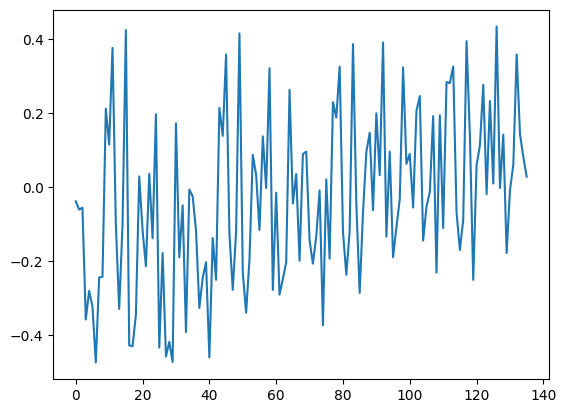

In [17]:
plt.plot(x2predictions)

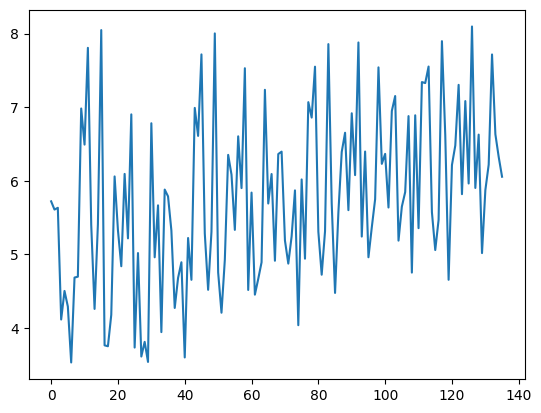

In [18]:
x2predictions = x2predictions.reshape(-1,1)
x2_pred = x2_scaler.inverse_transform(x2predictions).flatten()
plt.plot(x2_pred)

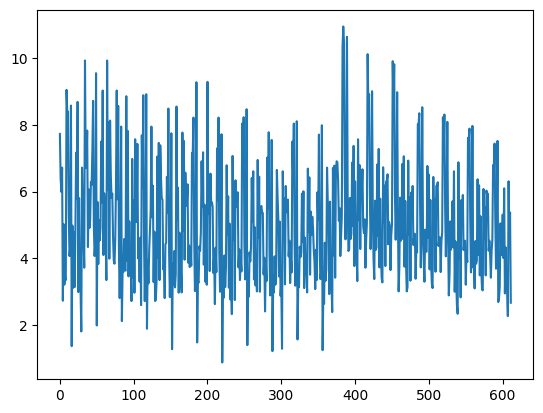

In [19]:
plt.plot(data['x2'])

### X3 (Rasio Gini)

In [20]:
initial_input_data = x3_norm[-34:,].reshape(1, -1)

# Number of future data points to predict
num_predictions = 136

# Placeholder for the predictions
predictions = []

# Initial input
current_input = initial_input_data

for _ in range(num_predictions):
    # Predict the next data point
    next_pred = modelx3.predict(current_input)
    
    # Append the prediction to the predictions list
    predictions.append(next_pred.squeeze())
    
    # Update the current input data for the next prediction
    # Drop the oldest point and append the new prediction
    current_input = np.append(current_input[:, 1:], next_pred, axis=1)

# Convert the list of predictions to a NumPy array
x3predictions = np.array(predictions)

print(x3predictions)

1/1 [==============================] - 0s 23ms/step
[-0.4044646  -0.29957414 -0.7213602  -0.1678037  -0.01479644 -0.06036001
 -0.11442953 -0.44939137 -0.9940318  -0.09898341  0.6865536   0.55700463
  0.24955305  0.6865536   0.27445295  0.235253    0.16947693  0.23329979
 -0.15421492 -0.3222332  -0.19512331 -0.2856654  -0.18362278 -0.6524763
  0.14589107 -0.450801    0.19610748  0.2438665   0.6177242   0.09190583
 -0.5405408  -0.33545804  0.20933321  0.42936453 -0.36747718 -0.32949996
 -0.7403183  -0.14725846 -0.05942589 -0.02971351 -0.1033653  -0.48640192
 -0.9948667  -0.08903265  0.6865536   0.56081724  0.30284134  0.681232
  0.23277327  0.26371604  0.20790944  0.2319789  -0.12271583 -0.39330757
 -0.22938448 -0.24856687 -0.17747527 -0.67125165  0.10921293 -0.41551864
  0.16990554  0.27482593  0.6448845   0.07099324 -0.5095738  -0.3394363
  0.2061564   0.44101745 -0.3407668  -0.36475098 -0.74246156 -0.15002865
 -0.09401065  0.00454062 -0.1002602  -0.5199349  -1.001099   -0.07343245
  0

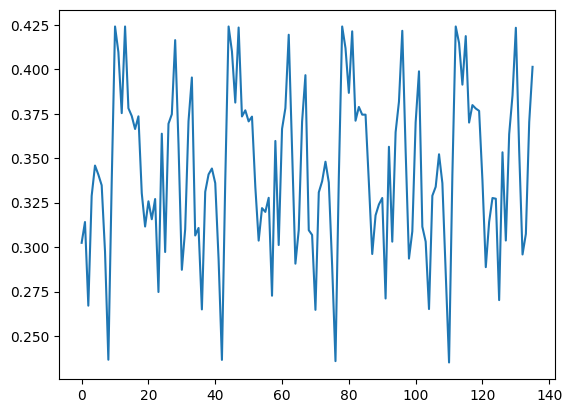

In [21]:
x3predictions = x3predictions.reshape(-1,1)
x3_pred = x3_scaler.inverse_transform(x3predictions).flatten()
plt.plot(x3_pred)

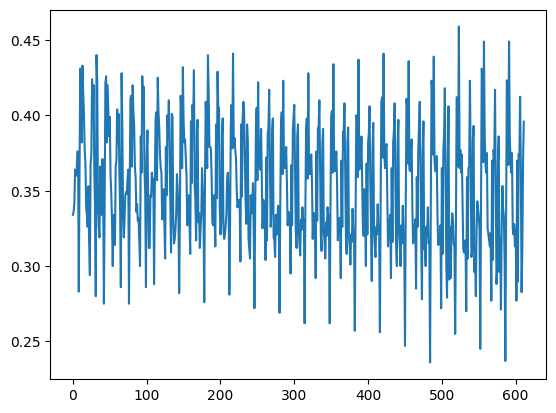

In [22]:
plt.plot(data['x3'])

## 10. Prediction Recap

In [23]:
model_pred = np.column_stack((x1_pred, x2_pred, x3_pred))
model_pred = pd.DataFrame(model_pred, columns=['x1', 'x2', 'x3'])
model_pred.to_excel('x_prediction.xlsx')